In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as sp
from PIL import Image
import math
import scipy.stats
Q_MATRIX = np.array([[8,8,6,6,4,4,2,2],
                       [8,8,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [2,2,2,2,2,2,2,2],
                       [2,2,2,2,2,2,2,2]],np.int32)

In [3]:
def snr(a):
    a = np.asanyarray(a, dtype="float")
    m = np.mean(a,axis=None)
    sd = np.std(a,axis=None,ddof=0)
    return np.where(sd == 0, 0, 10*np.log10(m/sd))

In [4]:
def psnr(a,oa):
    a = np.asanyarray(a, dtype="float")
    mse = np.square(oa-a).mean()
    return np.where(mse == 0, 0, 10*np.log10(255*255/mse))

In [5]:
def mse(og,new):
    return np.square(og-new).mean()

In [6]:
def dct_wave(N, w):
    wave = np.zeros(N, dtype='float')
    
    if (w==0):
        norm_factor = np.sqrt(1/N)
    else:
        norm_factor = np.sqrt(2/N)
    for i in range(N):   
        wave[i] = norm_factor * np.cos( w * (np.pi * (2*i + 1))/(2*N) )
        
    return wave

In [7]:
def dct_wave_2d(N, u, v):
    
    wave_x = dct_wave(N, u)
    wave_y = dct_wave(N, v)
    
    return np.outer(wave_x, wave_y)

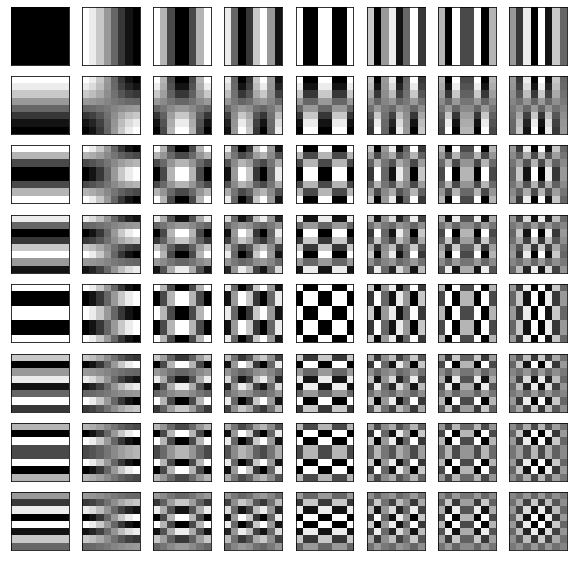

In [8]:
n = 8

fig = plt.figure(figsize=(10,10))
i = 0
for u in range(n):
    for v in range(n):
        
        plt.subplot(n,n,i+1)
        plt.imshow(dct_wave_2d(n, u, v), norm=None, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        i += 1

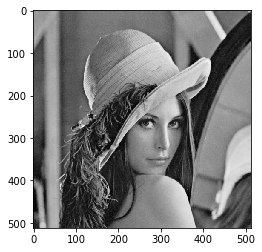

In [9]:
data_dir = r"C:\Users\callu\Pictures\Test\\"
#data_dir = r"./coursework-data/"
img = Image.open(data_dir+"lena.png").convert("L")
img = np.asarray(img)
plt.imshow(img, cmap="gray")
plt.show()
print(img.shape)

In [10]:
def DCT_inv(coeffs, dct_basis, N):
    recon = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            recon+=coeffs[k,l]*dct_basis[k,l]
    return recon

(512, 512)


In [11]:
def makeBasis(inp):
    inp=inp
    
    dct_basis = np.zeros((inp, inp, inp, inp)) 

    for k in range(inp):
        for l in range(inp):
            dct_basis[k, l] = dct_wave_2d(inp,k,l)
    
    return dct_basis

In [12]:
def dctBlock(im, dct_basis, N):
    coeffs = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            coefficient = np.dot(im.flatten(), dct_basis[k,l].flatten()) # dot product x.b
            coeffs[k,l] = coefficient
    return coeffs

In [48]:
def bdctTransform(image, bs, t=0, q=False):
    base = makeBasis(bs)
    dctim = np.zeros((image.shape))
    for i in range(0,image.shape[0],bs):
        for j in range(0,image.shape[1],bs):
            im = image[i:i+bs,j:j+bs]
            dctres = dctBlock(im,base,bs)
            if t<=0:
                None
            else:
                dctres = blockThresh(dctres, t)
            if q == True:
                dctres = qBlock(dctres)
            dctim[i:i+bs,j:j+bs] = dctres
    return dctim

In [27]:
def bidctTransform(dctim, bs):
    base = makeBasis(bs)
    recim = np.zeros((dctim.shape))
    for i in range(0,dctim.shape[0],bs):
        for j in range(0,dctim.shape[1],bs):
            im = dctim[i:i+bs,j:j+bs]
            recres = DCT_inv(im,base,bs)
            recim[i:i+bs,j:j+bs] = recres
    return recim

In [15]:
def blockThresh(block, thresh):
    bign = 0
    bigs = 0
    for r in block:
        for c in r:
            if c>bigs:
                if c>bign:
                    bigs=bign
                    bign=c
                bigs=c
    for x in range(block.shape[0]):
        for y in range(block.shape[0]):
            if abs(block[x,y])<thresh*bigs:
                block[x,y] = 0
    return block

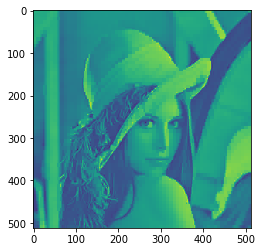

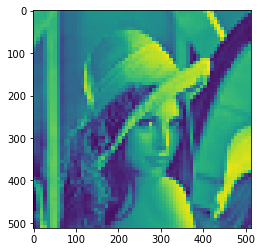

In [49]:
threshd = []
for i in range(0,10):
    thresh = i/10
    threshd.append(bidctTransform(bdctTransform(img,8,thresh),8))
    
plt.imshow(threshd[1])
plt.show()
plt.imshow(threshd[8])
plt.show()

In [17]:
#regular signal-to-noise
print(snr(img))
print(snr(threshd[0]))
print(snr(threshd[2]))
print(snr(threshd[4]))
print(snr(threshd[6]))
print(snr(threshd[8]))

4.119021912146391
4.119021912146391
4.282384656835106
4.36759545806292
4.396642757287043
4.4017570365256695


In [18]:
#peak-signal-to-noise
#seems more common in image analysis
#function hardcoded with assumption that each pixel is being represented with 8-bits
print(psnr(img,img))
print(psnr(threshd[0],img))
print(psnr(threshd[1],img))
print(psnr(threshd[2],img))
print(psnr(threshd[4],img))
print(psnr(threshd[6],img))
print(psnr(threshd[8],img))

0.0
298.9950159322125
28.653230522152473
25.93064148052172
24.191486564224988
23.73997579819558
23.665703202476593


C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [19]:
MSE = mse(img, threshd[1])
print(MSE)

88.66603922456085


In [20]:
def qBlock(block, target=Q_MATRIX):
    quant = np.zeros(target.shape)
    #print(target)
    for x in range(block.shape[0]):
        for y in range(block.shape[1]):
            quant[x,y] = round(block[x,y]/target[x,y])*target[x,y]
    return quant

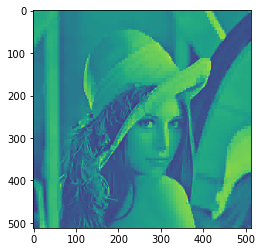

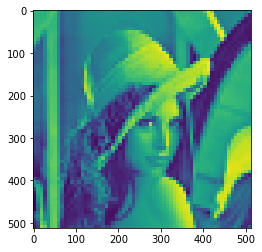

In [21]:
quantd = []
for i in range(0,10):
    thresh = i/10
    quantd.append(bidctTransform(bdctTransform(img,8,thresh,True),8))
    
plt.imshow(quantd[1])
plt.show()
plt.imshow(quantd[8])
plt.show()

In [22]:
print(snr(img))
print(snr(quantd[0]))
print(snr(quantd[2]))
print(snr(quantd[4]))
print(snr(quantd[6]))
print(snr(quantd[8]))

4.119021912146391
4.118053267028781
4.282659548319537
4.36781614643672
4.396830807412411
4.4019141009042535


In [23]:
print(psnr(img,img))
print(psnr(quantd[0],img))
print(psnr(quantd[1],img))
print(psnr(quantd[2],img))
print(psnr(quantd[4],img))
print(psnr(quantd[6],img))
print(psnr(quantd[8],img))

0.0
46.54650166522133
28.647174930261198
25.928145419360806
24.18999238410333
23.73864994451433
23.664401089205565


C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [24]:
MSE = mse(img, quantd[1])
print(MSE)

88.78975708788661


43.52046211247209
88.66603922456085
181.90360247098613
366.52472030024796


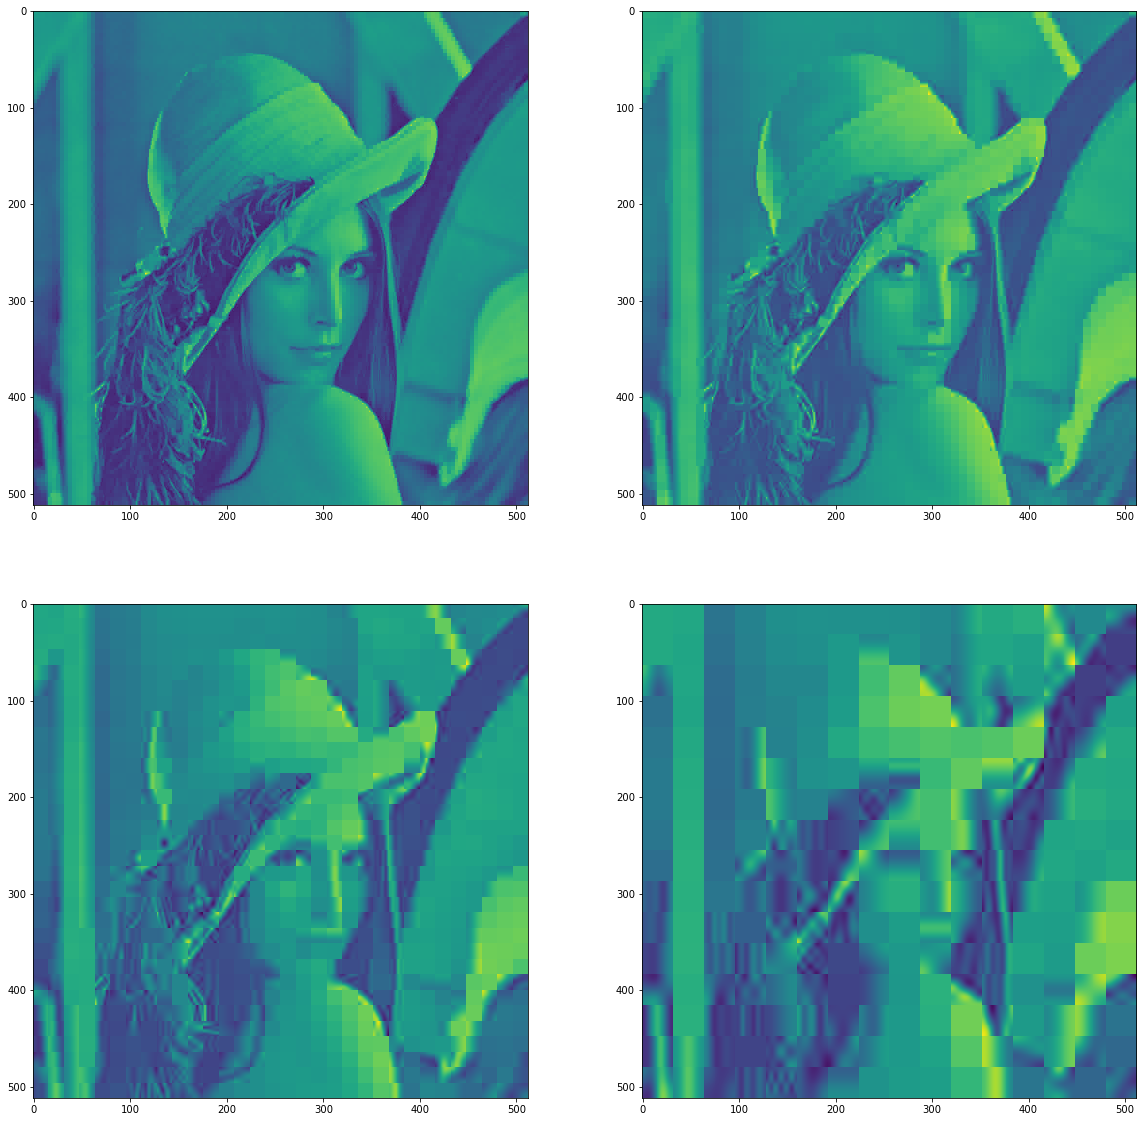

In [33]:
thresh = 0.1
four = bidctTransform(bdctTransform(img,4,thresh),4)
print(mse(img,four))
eight = bidctTransform(bdctTransform(img,8,thresh),8)
print(mse(img,eight))
sixteen = bidctTransform(bdctTransform(img,16,thresh),16)
print(mse(img,sixteen))
thirtytwo = bidctTransform(bdctTransform(img,32,thresh),32)
print(mse(img,thirtytwo))
fig = plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(four)
plt.subplot(2,2,2)
plt.imshow(eight)
plt.subplot(2,2,3)
plt.imshow(sixteen)
plt.subplot(2,2,4)
plt.imshow(thirtytwo)
plt.show()

In [34]:
def gaussian_kernel(sigma, norm=True):
    
    size = int(np.ceil(6 * sigma))  # kernel width is 6 x sigma
    
    if (size%2==0): # is the size even?
        size = size + 1 # make it odd 
        
    kernel = np.zeros((size,size), dtype='float') # kernel array
    
    h = size//2 # half size
    for y in range(0,size):
        for x in range(0,size):
            x2 = (x-h)*(x-h)
            y2 = (y-h)*(y-h)
            kernel[y, x] = np.exp(-(x2+y2)/(2*sigma*sigma))
    
    if norm:
        kernel /= np.sum(kernel) # normalise the kernel
    
    return kernel

In [35]:
def conv2d(im, kernel):

    h = kernel.shape[0]//2 # half the kernel size
    impad = np.pad(im,h,"edge")
    output = np.zeros(im.shape, dtype='float')
    for i in range(h,impad.shape[0]-h):
        for j in range(h,impad.shape[1]-h):

            output[i-h, j-h] = np.dot(impad[i-h:i+h+1,j-h:j+h+1].flatten(), kernel.flatten())
    return output

In [36]:
def reduce(im, kernel):
    
    # blur the input 
    im_blurred = conv2d(im.astype('float'), kernel)
    plt.imshow(im_blurred)
    plt.show()
    print(im_blurred.shape)
    return im_blurred[::2,::2] # return subsampled version

def expand(im, kernel):

    # upsample by a factor of two by pixel duplication
    upsampled = np.zeros((2*im.shape[0], 2*im.shape[1]), dtype=im.dtype)
    print(upsampled.shape)
    for i in range(upsampled.shape[0]):
        for j in range(upsampled.shape[1]):
            upsampled[i, j] = im[i//2,j//2]

    # blur the upsampled image
    blurred = conv2d(upsampled.astype('float'), kernel)

    return blurred

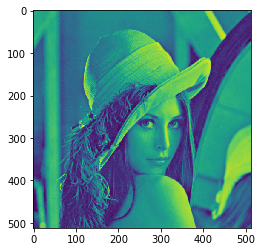

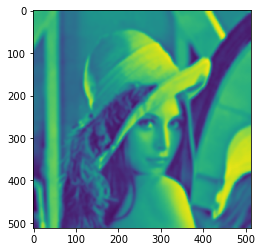

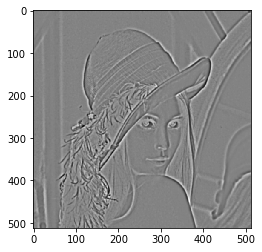

In [37]:
plt.imshow(img)
plt.show()

big = gaussian_kernel(3)
smol = gaussian_kernel(1)

blurred = conv2d(img,big)
padded_kernel = np.pad(smol, (big.shape[0]-smol.shape[0])//2, 'constant')
dog = big - padded_kernel

plt.imshow(blurred)
plt.show()

dogged = conv2d(img,dog)
plt.imshow(dogged, cmap="gray")
plt.show()

In [39]:
def build_pyramids(img, g):
    gauss_pyramid = [] # list to store the generated levels

    gauss_pyramid.append(img.astype('float')) # level 0 is the image

    n = int(np.log2(img.shape[0]))+1 # assume that the image size is a power of 2
    for i in range(1,n):

        print(i)
        
        level = reduce(gauss_pyramid[i-1], g)

        gauss_pyramid.append(level)

    lap_pyramid=[]
    for j in range(0,n-1):
        diff = gauss_pyramid[j]-expand(gauss_pyramid[j+1],g)
        lap_pyramid.append(diff)

    return gauss_pyramid,lap_pyramid

def show_pyramid(pyramid):

        fig = plt.figure(figsize=(18,7))

        for i in range(len(pyramid)):

            plt.subplot(2,5,i+1)
            plt.imshow(pyramid[i], cmap='gray')
            plt.title('level '+str(i))
            plt.xticks([])
            plt.yticks([])

        plt.show()

1


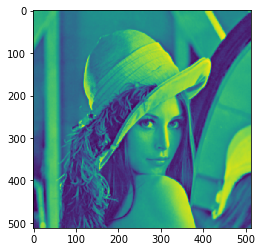

(512, 512)
2


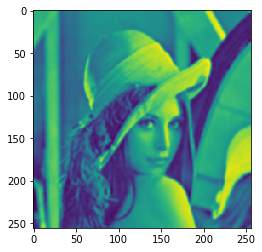

(256, 256)
3


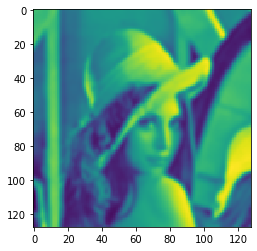

(128, 128)
4


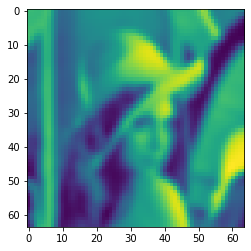

(64, 64)
5


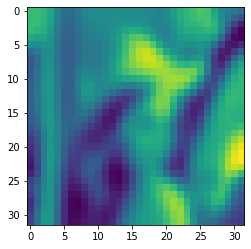

(32, 32)
6


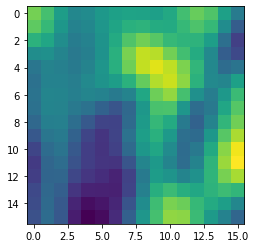

(16, 16)
7


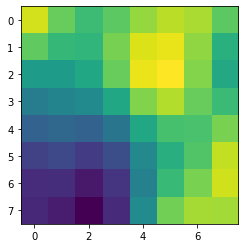

(8, 8)
8


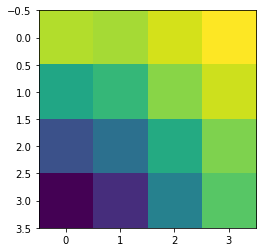

(4, 4)
9


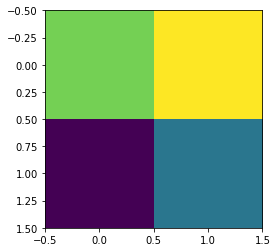

(2, 2)
(512, 512)
(256, 256)
(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)
(4, 4)
(2, 2)


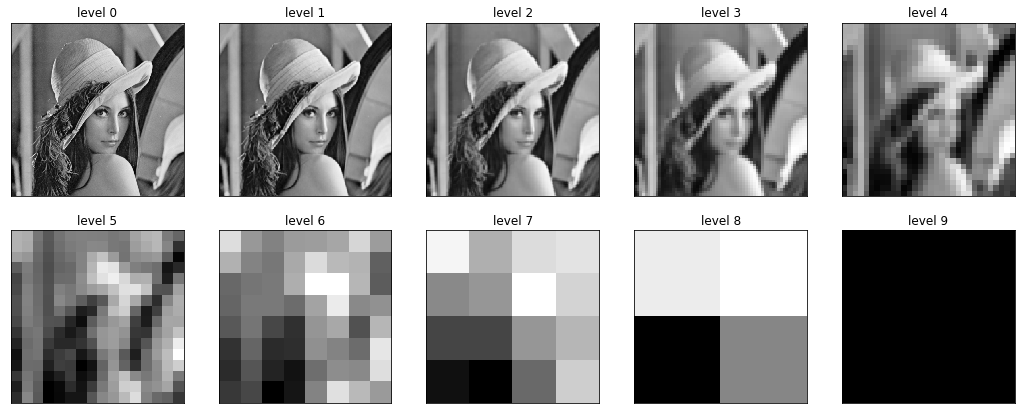

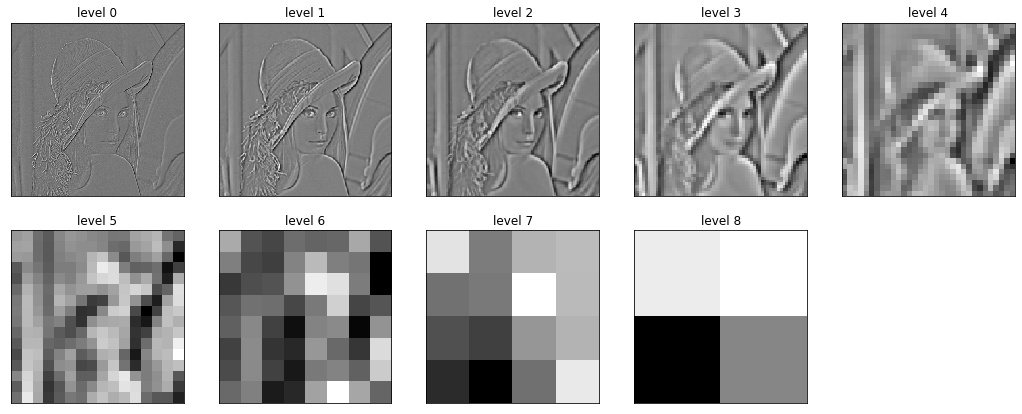

In [40]:
gauss,lapl = build_pyramids(img, smol)

show_pyramid(gauss)

show_pyramid(lapl)

93.9597474454078
72.0414003480061
73.09468966715372
55.76186859101128
56.83076394859336
46.49978741087932
36.29685607698809
14.507356157938375
7.067974949632713


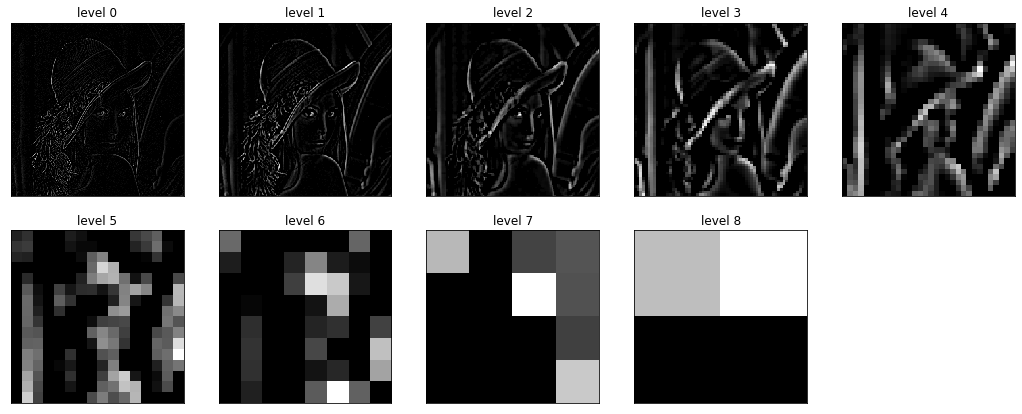

In [41]:
thresh_lap = []
for xj in range(len(lapl)):
    temp_store = []
    pmax = 0
    for pix in lapl[xj].ravel():
        if pix>pmax:
            pmax=pix
    print(pmax)
    for pix in lapl[xj].ravel():
        if pix>(0.02*pmax):
            temp_store.append(pix)
        else:
            temp_store.append(0)
    new_store = np.asarray(temp_store)
    thresh_lap.append(new_store.reshape((int(512//math.pow(2,(xj)))), int(512//math.pow(2,(xj)))))

show_pyramid(thresh_lap)